# Customer Churn Prediction


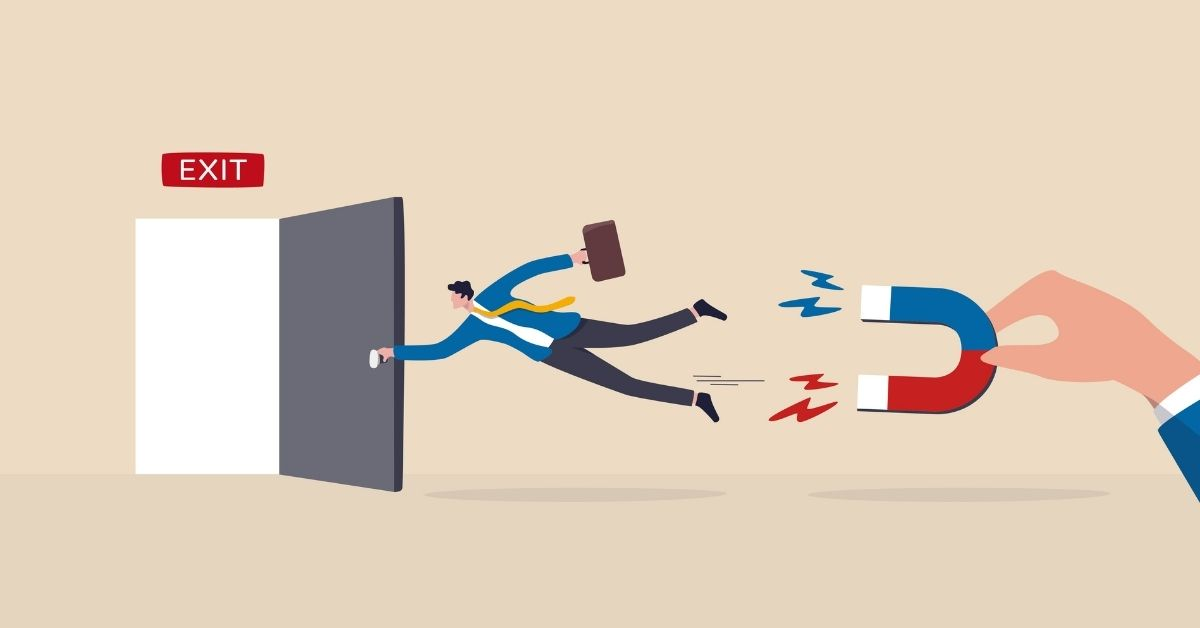

## Introduction


In the competitive landscape of telecommunications, retaining existing customers is as crucial as acquiring new ones. Customer churn, which occurs when subscribers discontinue their service, is a significant challenge and can lead to substantial revenue loss. The objective of this project is to develop a machine learning tool that predicts the likelihood of customers churning. By identifying at-risk customers, the telecom company can proactively engage them with targeted communication and retention strategies, such as special offers and promotions.

## Business Goal

The primary aim is not just to create a highly accurate churn prediction model, but to prioritize the identification of customers who are more likely to churn. The focus is on maximizing the model's recall for churned customers – we prefer to err on the side of flagging a customer as a potential churner rather than missing one. This allows the telecom company to cast a wider net with its retention campaigns, thereby potentially saving more customers from churning.



## Dataset

Loading dataset of Telco Customer Churn to DataFrame.

The Telco Customer Churn dataset from Kaggle is a comprehensive dataset used for analyzing customer behavior in the telecom industry. It includes customer demographics, service details, and a churn indicator, making it valuable for predictive modeling and understanding factors influencing customer retention. Widely used for educational and business applications, it serves as a practical case study in data science for processing, exploratory analysis, and machine learning, while also highlighting the importance of ethical considerations like privacy and data bias.

Made by IBM.

[Dataset can be found here.](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

> Indented block



In [118]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Feature engineering and data cleaning



In [119]:
df.rename(columns={'gender':'Gender'
                       ,'Contract':'ContractType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)

# Converting binary features to binary

cols = ['Partner', 'Dependents',  'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'PaperlessBilling', 'Churn']

for i in cols:
    df[i] = [1 if each == "Yes" else 0 if each == "No" else 0 for each in df[i]]


# Fixing TotalCharges so there would be no empty values
df.loc[df.TotalCharges ==' ','TotalCharges'] = np.nan

df.TotalCharges = df.TotalCharges.astype('float64')
# Calculating TotalCharges using Tenure and MonthlyCharges
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = df['MonthlyCharges'] * df['Tenure']

# Adding HasInternetService
df['HasInternetService'] = df.InternetService.map({'DSL':1,'Fiber optic':1,'No':0})
# Adding Is Contracted
df['HasContract'] = df.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
# Putting tenure into bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

df['TenureGroup'] = pd.cut(df.Tenure, range(1, 80, 12), right=False, labels=labels)
df['TenureGroup'].value_counts()
df = df.drop('Tenure', axis=1)
# Drop CustomerID
df = df.drop('customerID', axis=1)

df.head()

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,HasInternetService,HasContract,TenureGroup
0,Female,0,1,0,0,0,DSL,0,1,0,...,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0,1 - 12
1,Male,0,0,0,1,0,DSL,1,0,1,...,0,One year,0,Mailed check,56.95,1889.50,0,1,1,25 - 36
2,Male,0,0,0,1,0,DSL,1,1,0,...,0,Month-to-month,1,Mailed check,53.85,108.15,1,1,0,1 - 12
3,Male,0,0,0,0,0,DSL,1,0,1,...,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,1,37 - 48
4,Female,0,0,0,1,0,Fiber optic,0,0,0,...,0,Month-to-month,1,Electronic check,70.70,151.65,1,1,0,1 - 12


In [120]:
categorical_features = ['Gender','InternetService','PaymentMethod','ContractType', 'TenureGroup']
binary_features = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup'
               ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','HasInternetService'
               , 'HasContract']
numeric_features = ['MonthlyCharges']
target = 'Churn'

## Statistical Testing

In [121]:
from scipy.stats import chi2_contingency

# Combine categorical and binary features into one list for Chi-Square testing
all_nominal_features = categorical_features + binary_features

# Iterate over each feature and perform a Chi-Square test
for feature in all_nominal_features:
    contingency_table = pd.crosstab(df[feature], df.Churn)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print(f"Chi-Square test result for {feature}:")
    print(f"Chi2 Statistic: {chi2}, p-value: {p_value}\n")

Chi-Square test result for Gender:
Chi2 Statistic: 0.4840828822091383, p-value: 0.48657873605618596

Chi-Square test result for InternetService:
Chi2 Statistic: 732.309589667794, p-value: 9.571788222840544e-160

Chi-Square test result for PaymentMethod:
Chi2 Statistic: 648.1423274814, p-value: 3.6823546520097993e-140

Chi-Square test result for ContractType:
Chi2 Statistic: 1184.5965720837926, p-value: 5.863038300673391e-258

Chi-Square test result for TenureGroup:
Chi2 Statistic: 881.7597847281771, p-value: 2.358395063933462e-188

Chi-Square test result for SeniorCitizen:
Chi2 Statistic: 159.42630036838742, p-value: 1.510066805092378e-36

Chi-Square test result for Partner:
Chi2 Statistic: 158.7333820309922, p-value: 2.1399113440759935e-36

Chi-Square test result for Dependents:
Chi2 Statistic: 189.12924940423474, p-value: 4.9249216612154196e-43

Chi-Square test result for PhoneService:
Chi2 Statistic: 0.9150329892546948, p-value: 0.3387825358066928

Chi-Square test result for Multipl

### Conclusion

**Gender: Doesn't seem to be a good predictor of churn.**

InternetService: Seems to be a good predictor of churn.

PaymentMethod: Seems to be a good predictor of churn.

ContractType: Seems to be a good predictor of churn.

TenureGroup: Seems to be a good predictor of churn.

SeniorCitizen: Seems to be a good predictor of churn.

Partner: Seems to be a good predictor of churn.

Dependents: Seems to be a good predictor of churn.

**PhoneService: Doesn't seem to be a good predictor of churn.**

MultipleLines: Seems to be a good predictor of churn.

OnlineSecurity: Seems to be a good predictor of churn.

OnlineBackup: Seems to be a good predictor of churn.

DeviceProtection: Seems to be a good predictor of churn.

TechSupport: Seems to be a good predictor of churn.

StreamingTV: Seems to be a good predictor of churn.

StreamingMovies: Seems to be a good predictor of churn.

PaperlessBilling: Seems to be a good predictor of churn.

HasInternetService: Seems to be a good predictor of churn.

HasContract: Seems to be a good predictor of churn.


### Generating binary features from categorical features using One Hot Encoding

In [122]:
df = pd.get_dummies(df, columns=categorical_features)
df.head()

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod_Mailed check,ContractType_Month-to-month,ContractType_One year,ContractType_Two year,TenureGroup_1 - 12,TenureGroup_13 - 24,TenureGroup_25 - 36,TenureGroup_37 - 48,TenureGroup_49 - 60,TenureGroup_61 - 72
0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,1,0,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,0,0,1,0,1,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


This makes categorical features useful.

## Exploratory data analysis

### Checking if there are any null values

In [123]:
df.isnull().sum()


SeniorCitizen                              0
Partner                                    0
Dependents                                 0
PhoneService                               0
MultipleLines                              0
OnlineSecurity                             0
OnlineBackup                               0
DeviceProtection                           0
TechSupport                                0
StreamingTV                                0
StreamingMovies                            0
PaperlessBilling                           0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
HasInternetService                         0
HasContract                                0
Gender_Female                              0
Gender_Male                                0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
PaymentMet

No null values mean that the data is clean.

### Shape of the data

In [124]:
print("Records, features")
df.shape

Records, features


(7043, 35)

### Clean duplicates

In [125]:
df.duplicated().sum()
df = df.drop_duplicates()
df.duplicated().sum()

0

## Describe the data

In [126]:
df.describe()

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod_Mailed check,ContractType_Month-to-month,ContractType_One year,ContractType_Two year,TenureGroup_1 - 12,TenureGroup_13 - 24,TenureGroup_25 - 36,TenureGroup_37 - 48,TenureGroup_49 - 60,TenureGroup_61 - 72
count,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,...,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000
mean,0.162512,0.484546,0.300527,0.902863,0.423159,0.287566,0.345962,0.344965,0.291127,0.385558,...,0.227318,0.548782,0.209799,0.241419,0.306651,0.145848,0.118502,0.108532,0.118502,0.200399
std,0.368947,0.499797,0.458520,0.296166,0.494095,0.452660,0.475715,0.475391,0.454314,0.486761,...,0.419130,0.497650,0.407194,0.427974,0.461136,0.352979,0.323224,0.311073,0.323224,0.400327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


You can see the mean for the feature distribution.

### Churned vs Non-Churned users

0    0.735508
1    0.264492
Name: Churn, dtype: float64

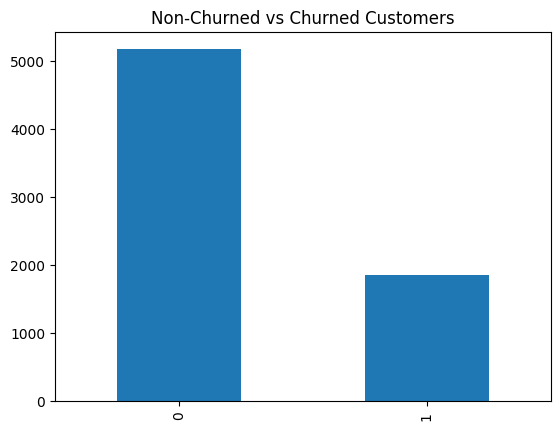

In [127]:
df['Churn'].value_counts()
df['Churn'].value_counts().plot(kind='bar', title='Non-Churned vs Churned Customers')
df.Churn.value_counts(normalize=True)

**Thoughts:** It seems that more users stay with the company. Therefore, we need to consider that the model can be more biased to predict users to be non-churned.

## Feature correlation with churn

<Axes: >

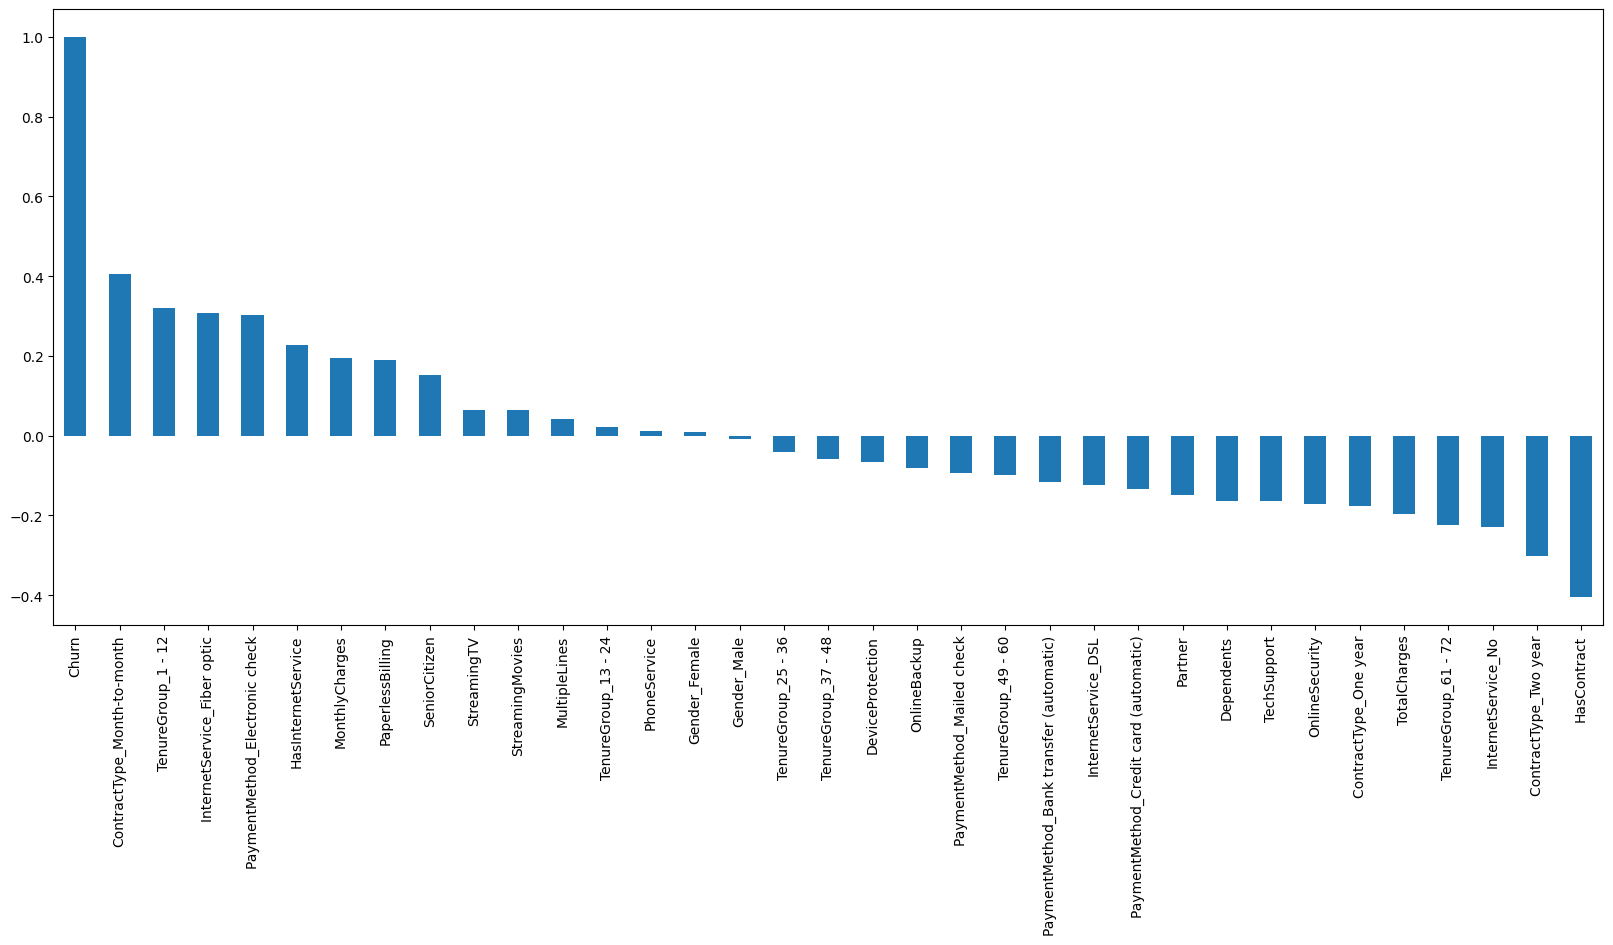

In [128]:
plt.figure(figsize=(20,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

## Correlation between features

<Axes: >

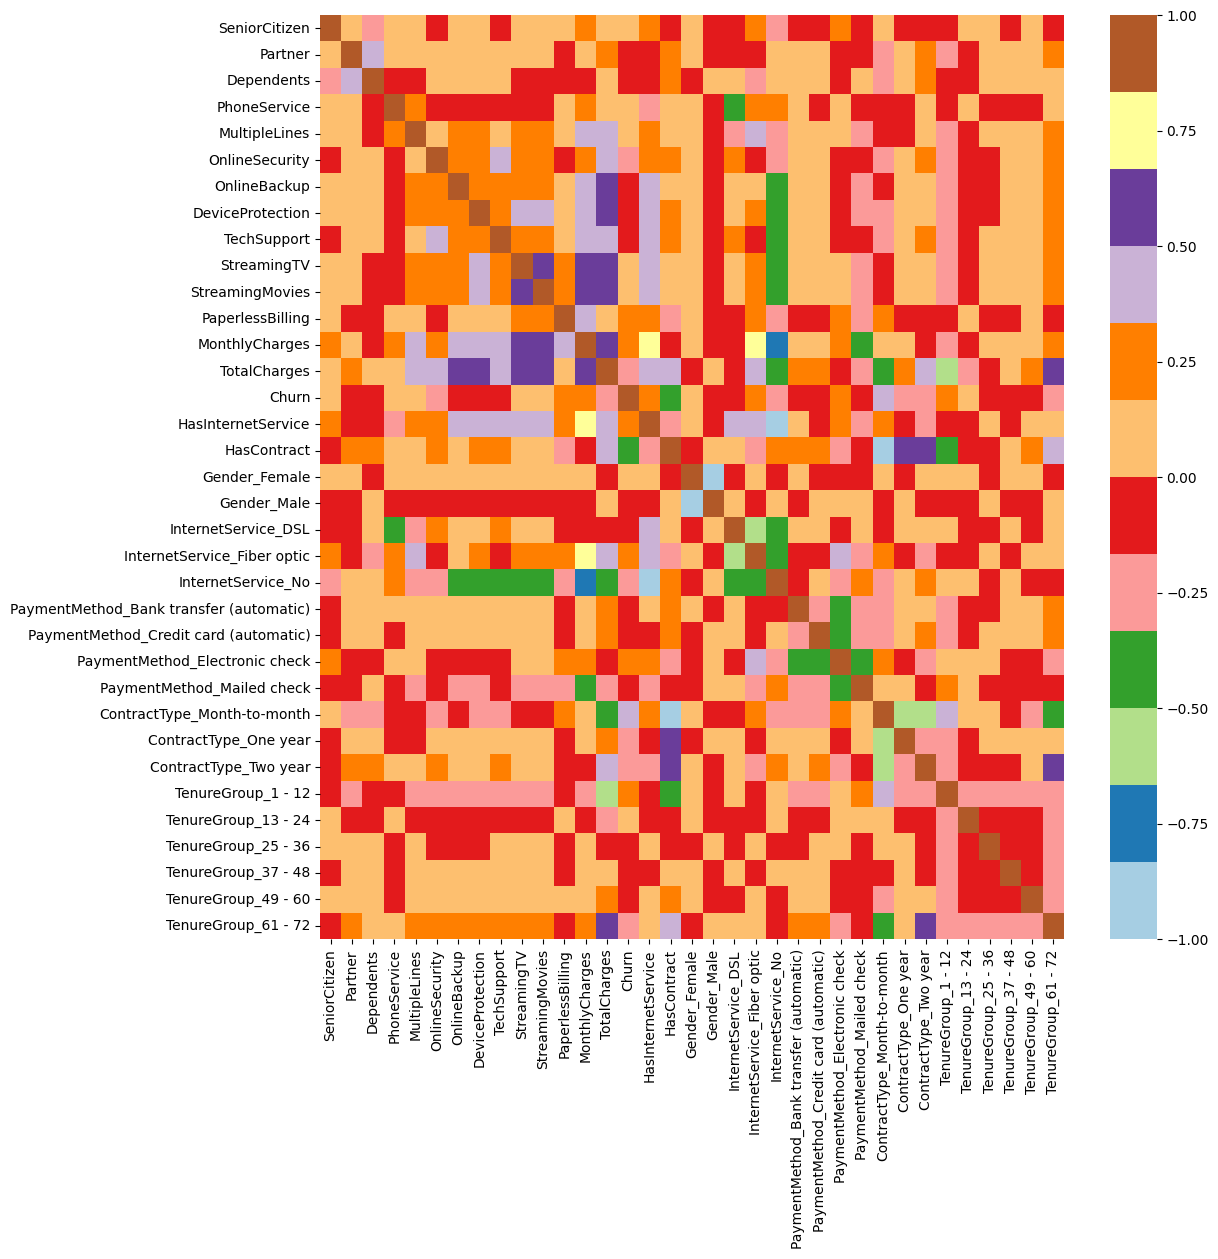

In [129]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap="Paired")

### EDA conclusion

The correlation graph presents an insightful overview of how different features within the Telco dataset may influence customer churn.

**Notably:**

**Contract Type:** Customers with month-to-month contracts show a strong positive correlation with churn, suggesting that customers not bound by long-term contracts are more likely to leave the service. Conversely, longer-term contracts (one-year and two-year) are negatively correlated with churn, indicating more stability with these customers.

**Tenure Groups:** There's a notable trend where shorter tenure correlates positively with churn, which aligns with the intuition that new customers are more prone to churn. Longer tenure groups exhibit negative correlations, highlighting the retention of more established customers.

**Payment Methods:** The method of payment also appears to impact churn rates. Automated payments (like bank transfers and credit cards) have a negative correlation with churn, whereas electronic checks are positively correlated, suggesting that customers using electronic checks are more likely to churn.

**Services:** Certain services such as online security, tech support, and device protection are negatively correlated with churn, implying that customers who subscribe to these services are less likely to churn. This could indicate that the perceived value or customer satisfaction with these services contributes to customer retention.

**Demographics:** Gender shows a very low correlation with churn, suggesting that churn behavior does not differ significantly between males and females in this dataset. The 'SeniorCitizen' feature has a positive correlation, indicating that senior citizens are more likely to churn compared to non-senior citizens.

**Billing and Charges:** Interestingly, customers with paperless billing and those with higher monthly charges are more correlated with churn, which might reflect customer sensitivity to price or a preference for traditional billing methods.

## Choosing a Model


After thorough exploratory data analysis (EDA) on the Telco customer dataset, I believe **logistic regression** and **decision tree** models could serve as a beneficial models as both are suited well for binary outcomes.



## Building a logistic regression model

Given our primary objective to engage with the maximum number of customers at risk of churn, our focus is on maximizing recall to minimize false negatives. High recall ensures that we correctly identify and reach out to as many potentially churning customers as possible.

To achieve this, we must address the class imbalance inherent in our dataset, as an uneven distribution of churned versus non-churned customers can bias the model towards the majority class. Additionally, we will implement feature scaling to ensure that our model accurately captures the importance of each predictor without being skewed by the range of values.

### Class weigthing

In [130]:
df.Churn.value_counts(normalize=True)

0    0.735508
1    0.264492
Name: Churn, dtype: float64

Let's create weights based on class ratios.

In [131]:
weight_for_0 = 1 / 0.73463
weight_for_1 = 1 / 0.26537

weight_for_0 = weight_for_0 / min(weight_for_0, weight_for_1)
weight_for_1 = weight_for_1 / min(weight_for_0, weight_for_1)

class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight = compute_class_weight('balanced', classes=[0, 1], y=df[target])
class_weight_dict = {0: class_weight[0], 1: class_weight[1]}

### Scaling and regularization

Let's divide by maximum value, so the values would be low.

In [132]:
df['MonthlyCharges'] = df['MonthlyCharges'] / df['MonthlyCharges'].max()

df['TotalCharges'] = df['TotalCharges'] / df['TotalCharges'].max()

df.head()

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod_Mailed check,ContractType_Month-to-month,ContractType_One year,ContractType_Two year,TenureGroup_1 - 12,TenureGroup_13 - 24,TenureGroup_25 - 36,TenureGroup_37 - 48,TenureGroup_49 - 60,TenureGroup_61 - 72
0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,1,0,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,0,0,1,0,1,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


### Training

In [133]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [134]:
model = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(class_weight={0: 0.6798024786986832, 1: 1.89041464728056},
                   max_iter=1000)

### Evaluation

In [135]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1053
           1       0.47      0.79      0.59       352

    accuracy                           0.73      1405
   macro avg       0.69      0.75      0.69      1405
weighted avg       0.80      0.73      0.74      1405

Accuracy: 0.7259786476868327


### Resampling

In [136]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1053
           1       0.44      0.91      0.59       352

    accuracy                           0.68      1405
   macro avg       0.69      0.76      0.67      1405
weighted avg       0.82      0.68      0.70      1405

Accuracy: 0.6832740213523132


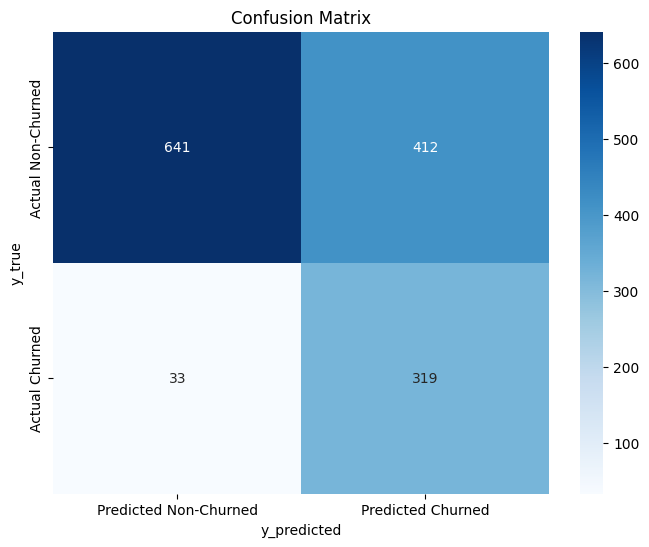

In [137]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Non-Churned', 'Predicted Churned'], yticklabels=['Actual Non-Churned', 'Actual Churned'])
plt.ylabel('y_true')
plt.xlabel('y_predicted')
plt.title('Confusion Matrix')
plt.show()

In [138]:
tn, fp, fn, tp = cm.ravel()

print(f'True Negatives (TN): {tn}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')
print(f'True Positives (TP): {tp}')

True Negatives (TN): 641
False Positives (FP): 412
False Negatives (FN): 33
True Positives (TP): 319


### Conclusions for logistic regression


The Logistic Regression model, refined with class weighting and resampling, demonstrated a nuanced shift in handling class imbalance:

**Class 0 (Majority): After resampling, saw a precision of 0.95, recall of 0.61, and F1-score of 0.74.**

**Class 1 (Minority): Exhibited an improved precision of 0.44, a significantly higher recall of 0.91, and F1-score of 0.59.**

The overall accuracy was adjusted to 0.68. Class weighting initially helped in balancing the model's performance, but it was the resampling that notably enhanced the model's ability to identify the minority class, evident in the increased recall for Class 1.

In summary, the application of class weighting, followed by resampling, effectively shifted the model's focus towards the minority class, resulting in improved detection at the cost of some reduction in overall accuracy and majority class recall. This approach marks a strategic move towards prioritizing minority class prediction in an imbalanced dataset.

## Building a decision tree model


In [139]:
from sklearn.tree import DecisionTreeClassifier

## Using the model with class weights and pruning the tree, to not overfit
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced', random_state=42)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, random_state=42)

## Evalutation of decision tree model

In [140]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1053
           1       0.45      0.80      0.58       352

    accuracy                           0.71      1405
   macro avg       0.68      0.74      0.68      1405
weighted avg       0.80      0.71      0.73      1405

Accuracy: 0.7096085409252669


## Resampling

In [141]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
dt_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1053
           1       0.50      0.68      0.57       352

    accuracy                           0.75      1405
   macro avg       0.69      0.72      0.70      1405
weighted avg       0.78      0.75      0.76      1405

Accuracy: 0.7466192170818505


## Visualization

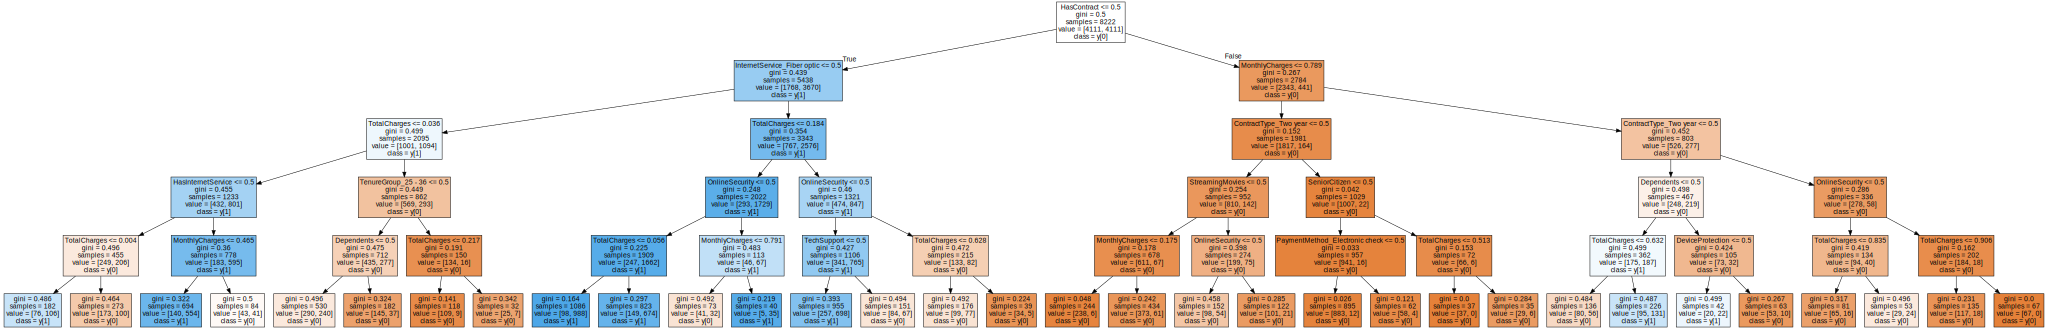

In [142]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to a tree.dot file for visualizing
export_graphviz(dt_model, out_file='tree.dot',
                feature_names = X_train.columns,
                class_names = True,
                filled = True)

# Use graphviz to plot the tree
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Conclusions of decision tree model

The Decision Tree model, enhanced with resampling, pruning, and class weighting, showed improved balance and performance in addressing class imbalance:

**Class 0 (Majority): Precision of 0.88, recall of 0.77, F1-score of 0.82.**

**Class 1 (Minority): Precision of 0.50, recall of 0.68, F1-score of 0.57.**


Overall accuracy reached 0.75. Pruning and class weighting effectively mitigated overfitting and imbalance bias, respectively, while resampling balanced class representation. The combined approach led to a more accurate, fair model, evident in improved precision for Class 1 and overall accuracy.

In summary, the model's performance benefitted significantly from these combined strategies, resulting in a more effective handling of an imbalanced dataset.


# Final Thoughts

Upon comparing the performances of the Decision Tree and Logistic Regression models, both enhanced with techniques to address class imbalance, we observe distinct characteristics and suitability for different objectives:

## Decision Tree Model:
Demonstrated a more balanced performance across both classes with:

**Class 0 (Majority): Precision of 0.88, recall of 0.77, F1-score of 0.82.**

**Class 1 (Minority): Precision of 0.50, recall of 0.68, F1-score of 0.57.**

* Achieved an overall accuracy of 0.75.
* Benefitted from resampling, pruning, and class weighting, leading to a fairer representation of both classes.
* Suitable for scenarios where a balanced trade-off between precision and recall across both classes is desired.

## Logistic Regression Model:

After resampling and class weighting, showed a significant improvement in detecting the minority class with:

**Class 0: Precision of 0.95, recall of 0.61, F1-score of 0.74.**
**Class 1: Precision of 0.44, recall of 0.91, F1-score of 0.59.**

* Reached an overall accuracy of 0.68.
* Displayed a marked inclination towards accurately predicting the minority class at the expense of reduced overall accuracy and majority class recall.
* Ideal for situations where identifying the minority class (Class 1) is crucial, even if it means a slight compromise on the majority class's recall.


## Final Conclusion:
Decision Tree Model is preferable when a more balanced approach to both classes is required.

It offers a better compromise between identifying both classes accurately, making it suitable for contexts where errors in either class have similar consequences.

Logistic Regression Model excels in scenarios where the priority is to minimize false negatives for the minority class (Class 1).

This model is more apt for situations where failing to detect instances of the minority class could have more severe repercussions than false positives in the majority class.

In summary, the choice between the two models depends on the specific requirements and priorities of your use case. If equal importance is given to both classes, the Decision Tree model might be more appropriate

**However, since the focus is predominantly on correctly identifying the minority class, the Logistic Regression model would be the better choice.**

# Export

Let's export the model into a file.

In [144]:
from joblib import dump

dump(model, 'logistic_model.pkl')
dump(dt_model, 'dt_model.pkl')

['dt_model.pkl']